In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import torch
import nibabel
import data.constants as constants
import nilearn.masking as masking
import numpy as np
import pandas as pd
from data import ward_tree
import nibabel
from nilearn.image import load_img, resample_img, crop_img, threshold_img, math_img
import nilearn.masking as masking
from nilearn import plotting
import itertools


/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/site-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The 

In [2]:
from clevr.modules import classifiers
# classifiers.versions['fc']

cairo was not found. ignoring and moving on.


/data/brain_/utils/utils.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda/envs/py35/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda/envs/py35/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/anaconda/envs/py35/lib/pytho

ImportError: No module named 'torch_scatter'

iidxclustergrid50000_df0.2_1 fc: mean acc=0.1289 std=0.0016 loss=0.0026
iidxclustergrid50000_df0.2_1 bigconv: mean acc=0.1433 std=0.0126 loss=0.0156
iidxclustergrid50000_df0.2_1 bigcc: mean acc=0.1388 std=0.0131 loss=0.0244
iidxclustergrid50000_df0.2_1 regionfgl: mean acc=0.1325 std=0.0076 loss=10.0674
iidxclustergrid50000_df0.2_10 fc: mean acc=0.1544 std=0.0037 loss=0.0017
iidxclustergrid50000_df0.2_10 bigconv: mean acc=0.1430 std=0.0045 loss=0.4304
iidxclustergrid50000_df0.2_10 bigcc: mean acc=0.1441 std=0.0075 loss=0.6835
iidxclustergrid50000_df0.2_10 regionfgl: mean acc=0.1535 std=0.0071 loss=1.1480
iidxclustergrid50000_df0.2_50 fc: mean acc=0.1966 std=0.0021 loss=0.0000
iidxclustergrid50000_df0.2_50 bigconv: mean acc=0.1934 std=0.0269 loss=3.6510
iidxclustergrid50000_df0.2_50 bigcc: mean acc=0.1961 std=0.0246 loss=3.8095
iidxclustergrid50000_df0.2_50 regionfgl: mean acc=0.1972 std=0.0050 loss=0.0011
iidxclustergrid50000_df0.2_100 fc: mean acc=0.2186 std=0.0043 loss=0.0004
iidxclus

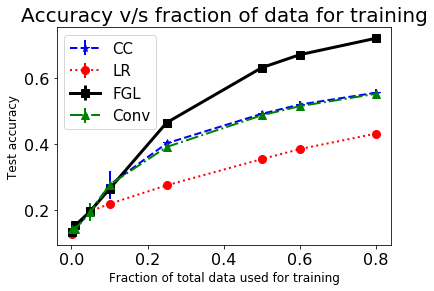

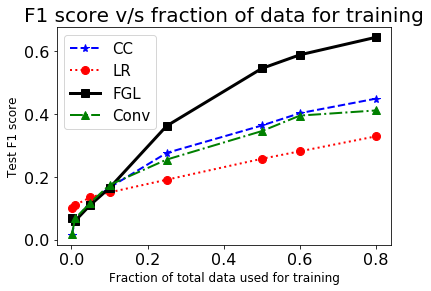

In [4]:
# Larger dataset sizes
from collections import defaultdict
outputs_dir = ["/data/brain_/sanity_clevr/outputs/multi_run"]

# models = ["fc", "conv", "cc", "complexwedgefgl"]
# datasets = ["complexwedges50000"]  # ["somewhat", "notso", "bignotso"]
# fracs = [0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
models = ["fc", "bigconv", 'bigcc', "regionfgl"]
modules = defaultdict(dict)
datasets = ['iidxclustergrid50000']
testing_frac = 0.2
fracs = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.6, 0.8]

datasets = [ x + '_df{}_'.format(testing_frac) + str(int(1000 * y)) for x in datasets for y in fracs]
accs_dict = defaultdict(list)
f1s_dict = defaultdict(list)
stds_dict = defaultdict(list)
for ds, od, mt  in itertools.product(datasets, outputs_dir, models):
    chk = torch.load(os.path.join(od, mt, ds, "last_metrics.checkpoint"))
    specific_args = torch.load(os.path.join(od, mt, ds, "args.checkpoint"))
    accs = []
    f1s = []
    loss = []
    for i in range(10):
        if ds.endswith('800') and (i == 0):
            objchk = torch.load(os.path.join(od, mt, ds, "outer_split{}".format(i), "last.checkpoint"))
#             modules[mt] = classifiers.versions[mt](specific_args, objchk['model'])
            print('loaded {} for {}'.format(mt, ds))
        tochk = torch.load(os.path.join(od, mt, ds, "outer_split{}".format(i), "train_metrics_per_epoch.checkpoint"))
        ochk = torch.load(os.path.join(od, mt, ds, "outer_split{}".format(i), "test_metrics_per_epoch.checkpoint"))
        accs.append(ochk[-1]["accuracy"])
        f1s.append(np.min(ochk[-1]["f1"]))
        loss.append(tochk[-1]["loss"])
    accs_dict[mt].append(np.mean(accs))
    f1s_dict[mt].append(np.mean(f1s))
    stds_dict[mt].append(np.std(accs))
    print("{} {}: mean acc={:.4f} std={:.4f} loss={:.4f}".format(ds, mt, chk['accuracy'], np.std(accs), np.mean(loss)))
#     print("{} {}: mean acc={:.4f} std={:.4f}".format(ds[:-1], mt, chk['accuracy'], np.std(accs)))

baselw = 2
markersize = 8
plotting_params = {
    'fc': {'label': 'LR', 'linestyle':':', 'color':'r', 'linewidth': baselw, 'marker': 'o', 'markersize':markersize},
    'bigcc': {'label': 'CC', 'linestyle':'--', 'color':'b', 'linewidth': baselw, 'marker': '*', 'markersize':markersize},
    'bigconv': {'label': 'Conv', 'linestyle':'-.', 'color':'g', 'linewidth': baselw, 'marker': '^', 'markersize':markersize},
    'regionfgl': {'label': 'FGL', 'linestyle':'-', 'color':'k', 'linewidth': 3, 'marker': 's', 'markersize':markersize},
}

# plotting_params = {
#     'fc': {'marker': 'o',},
#     'bigcc': {'marker': '*',},
#     'bigconv': {'marker': '^',},
#     'complexwedgefgl': {'marker': 's',},
#     'regionfgl': {'marker': 's',},
# }
for mt in accs_dict.keys():
    plt.errorbar(fracs[:len(accs_dict[mt])], accs_dict[mt], yerr=stds_dict[mt], **plotting_params[mt])
plt.legend(loc='best', fontsize=15)
plt.title('Accuracy v/s fraction of data for training', fontsize=20)
plt.xlabel('Fraction of total data used for training', fontsize=12)
plt.ylabel('Test accuracy', fontsize=12)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 12)

plt.figure()
for mt in f1s_dict.keys():
    plt.errorbar(fracs[:len(f1s_dict[mt])], f1s_dict[mt], **plotting_params[mt])
plt.legend(loc='best', fontsize=15)
plt.title('F1 score v/s fraction of data for training', fontsize=20)
plt.xlabel('Fraction of total data used for training', fontsize=12)
plt.ylabel('Test F1 score', fontsize=12)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


generation of dataset took 10.169712781906128s
took 10.495883226394653s
10000


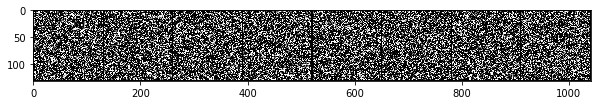

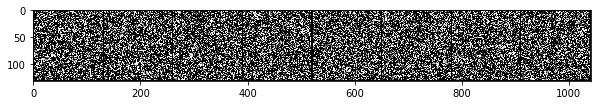

In [6]:
%autoreload 2
import time
from argparse import Namespace
from clevr import grid
import torchvision
args = specific_args
tic = time.time()
dset = grid.IIDXClusterGrid(args, n=10000)
print("took {}s".format(time.time() - tic))
print(len(dset))
images = []
for i in range(dset.n_classes):
    images.append(torch.from_numpy(dset[i][0]).view(1, dset.s, dset.s))
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(torchvision.utils.make_grid(images, nrow=dset.n_regions // 2).numpy(), [1, 2, 0]))

images = []
for i in range(dset.n_classes):
    images.append(torch.from_numpy(dset[i + dset.n_classes][0]).view(1, dset.s, dset.s))
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(torchvision.utils.make_grid(images, nrow=dset.n_regions // 2).numpy(), [1, 2, 0]))

Text(0.5,0,'Number of datapoints')

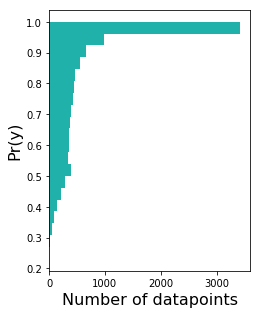

In [24]:
plt.figure(figsize=(3.6, 4.8))

plt.hist(dset.conf, bins=20, color='lightseagreen', orientation=u'horizontal')
# plt.title('Probability of assigned label', fontsize=17, loc='right')
plt.ylabel('Pr(y)', fontsize=16)
plt.xlabel('Number of datapoints', fontsize=16)

/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


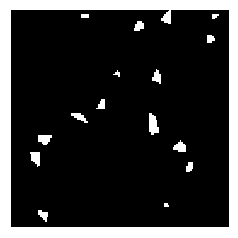

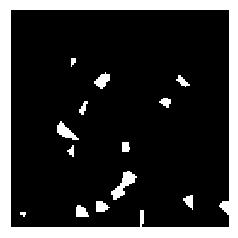

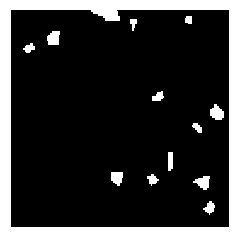

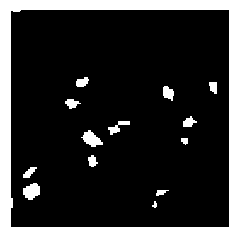

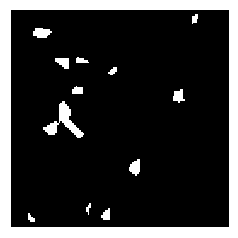

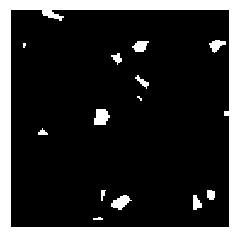

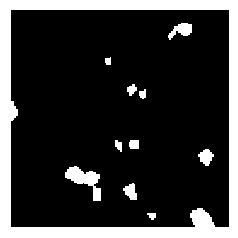

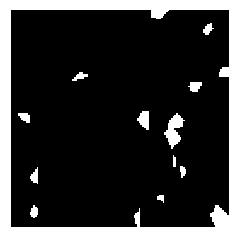

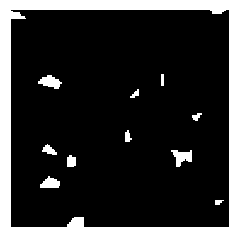

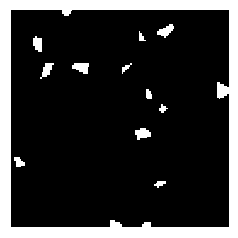

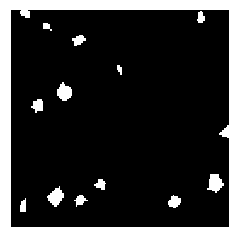

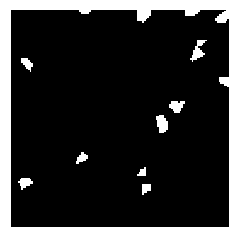

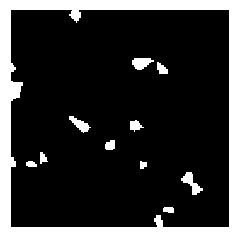

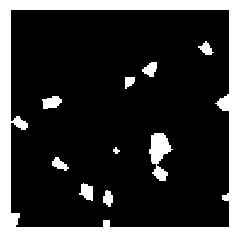

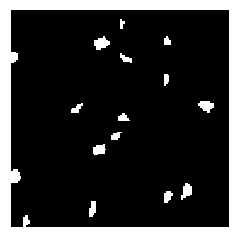

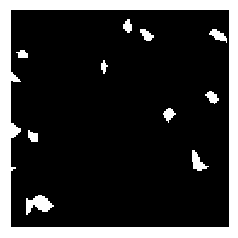

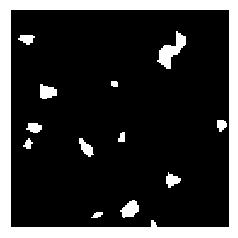

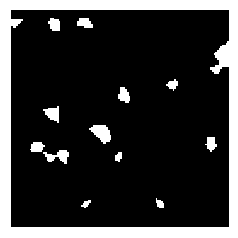

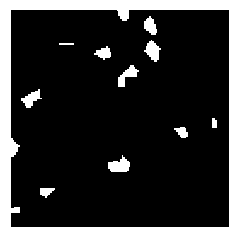

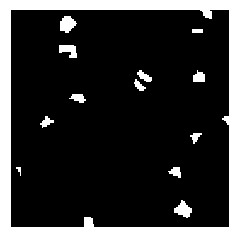

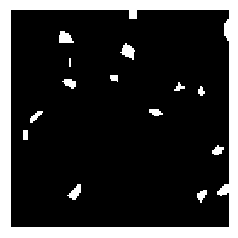

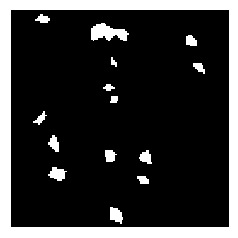

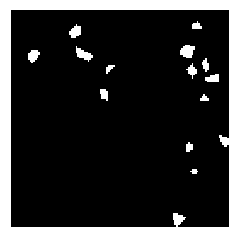

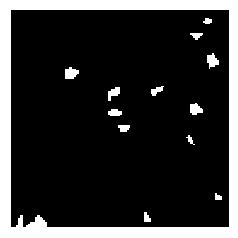

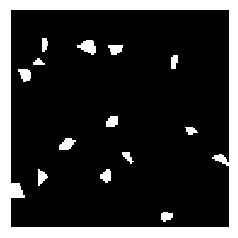

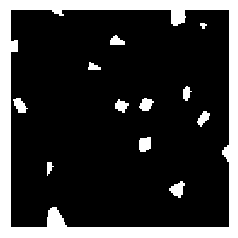

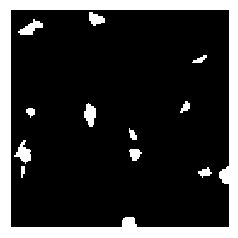

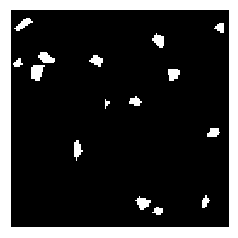

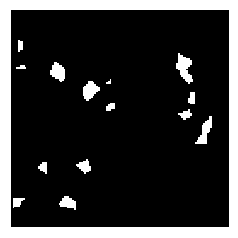

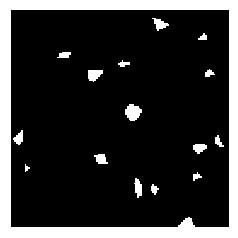

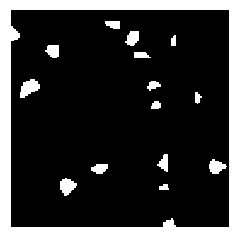

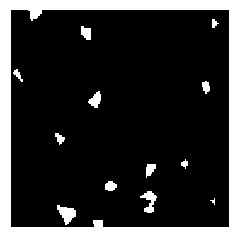

In [167]:
for i, r in dset.regions.items():
    plt.figure()
    plt.imshow(r, cmap='gray')
    plt.axis('off')
    plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')


In [168]:
from torch import nn
loader = torch.utils.data.DataLoader(dset, batch_size=1024)
ctrues = []
cpreds = defaultdict(list)
for mt in modules.keys():
    if not(isinstance(modules[mt], nn.DataParallel)):
        modules[mt] = nn.DataParallel(modules[mt].cuda())
with torch.no_grad():
    for bidx, (x, y) in enumerate(loader):
        print('{}/{}'.format(bidx, len(loader)))
        x = x.to('cuda:0')
        y = y.detach().numpy()
        ctrues.append(y)
        for mt, module in modules.items():
            yhat = module(x)
            cpred = torch.argmax(yhat, dim=1).detach().cpu().numpy()
            cpreds[mt].append(cpred)

0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10


In [169]:
allctrues = np.concatenate(ctrues)
allcpreds = {
    k: np.concatenate(v) for k, v in cpreds.items()
}

In [170]:
mistakes = {
    k: v != allctrues for k, v in allcpreds.items()
}

[-1.18495553e+01 -3.33794473e+01 -7.06239806e-01 -1.78378156e+01
 -2.57403883e+01 -1.18197563e+01  5.28114708e+01 -2.11010974e+01
  9.23921355e+00  1.84288079e+01  3.90737594e+01 -2.27721295e+00
 -1.68690408e+01 -1.69553159e+01  3.28029035e+01 -3.18188029e+00
 -1.83439987e+01  1.70442178e+01  3.29788960e+00 -2.21465065e+01
  1.55000304e+01 -6.56153422e-03  3.16002358e+01 -1.36980117e+01
  4.51798280e+01 -1.44435089e+01 -5.82756860e+01  5.26445375e-02
  1.00887923e+01 -3.68579905e+00  8.30478698e+00 -4.31358637e+00]
1
[-24.39890798 -19.73109786 -11.41102956   7.21093923  -3.87292961
  19.74125743   2.19627218  51.24390827  40.50019865   0.60593013
  -9.77871647  21.84776195  -4.38132942   1.32985187  -7.74065189
  -4.57647922   3.88367622   2.6848308   32.94830653 -39.79357808
   4.74572839 -18.03401729   6.81827858   5.49645619  16.45521605
  25.53494374 -33.67128928   2.72538965  21.25534512  -2.44091825
  15.09094282 -26.61901467]
4


/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


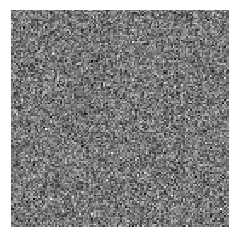

<Figure size 432x288 with 0 Axes>

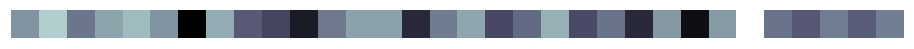

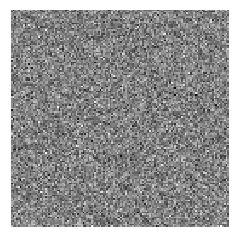

<Figure size 432x288 with 0 Axes>

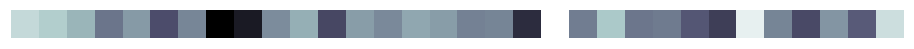

In [171]:
investigate_agree = investigate = np.where(np.logical_and(np.logical_not(mistakes['regionfgl']), np.logical_not(mistakes['bigconv'])))[0]
for idx, i in enumerate(investigate):
    if idx == 2:
        break
    x, y = dset[i]
    x_agg = np.matmul(dset.Ahx, np.reshape(x, (-1)))
    plt.figure()
    plt.imshow(x, cmap='gray')
    plt.axis('off')
    plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
    plt.figure()
    plt.matshow(np.array([x_agg]), cmap='bone_r')
    plt.axis('off')
    plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')

    print(x_agg)
    print(y)
    #     plt.title('{}: {}, {}'.format(i, y, x_agg))

[-28.35394062  25.39014932  28.31198462 -43.96514329   1.39346216
  34.98858138 -12.57441533  15.15852796  -2.7402138  -14.27090021
 -17.5846569   18.42535592  -1.83390701  -4.37210316  39.70598136
  -2.43742349 -36.97842051   6.18408601 -46.57696314  12.11018789
  -1.62179374  -5.65474282  -3.48509218  -1.55687991 -24.17920735
  35.06451461 -34.58031921  31.81515194  -1.5657847   34.40234653
  -7.35982705 -11.8734583 ]
5
[-22.18614267  16.58817193  25.34903612  13.43907879   1.33828032
 -14.92882599  28.61686522  38.66451717  27.92602333  24.25663833
  30.52631935   1.05767678   3.09788036  -7.60024241  23.29003695
  -8.54906379  12.60210368  39.56969801   1.11639363 -13.7436145
   4.31721329 -11.17081697   8.78529833 -12.2314846   -6.31496605
 -14.00161067 -35.91677339  25.82395236 -49.02166978  -3.21243328
  -0.95605582   5.38837905]
1


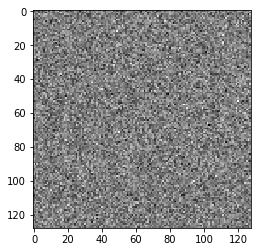

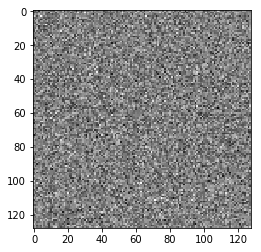

In [172]:
investigate_disagree = investigate = np.where(np.logical_and(np.logical_not(mistakes['regionfgl']), mistakes['bigconv']))[0]
for idx, i in enumerate(investigate):
    if idx == 2:
        break
    x, y = dset[i]
    x_agg = np.matmul(dset.Ahx, np.reshape(x, (-1)))
    plt.figure()
    plt.imshow(x, cmap='gray')
    print(x_agg)
    print(y)
#     plt.title('{}:{}, {}'.format(i, y, x_agg))

In [173]:
rds = []
for ag in investigate_agree[:100]:
    for dag in investigate_disagree[:100]:
        rds.append(np.matmul(dset.Ahx, np.reshape(dset[dag][0], (-1))) - np.matmul(dset.Ahx, np.reshape(dset[ag][0], (-1))))

In [127]:
rdiffs = np.stack(rds)

In [138]:
rdiffs.std(0)

24.16543663286139

Text(0,0.5,'Number of datapoints')

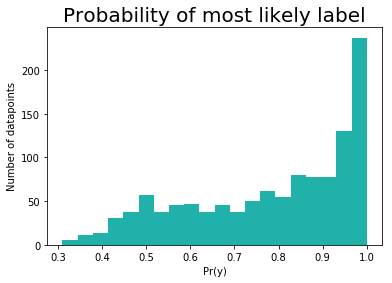

In [176]:
plt.figure()
plt.hist(dset.conf[investigate_disagree], bins=20, color='lightseagreen')
plt.title('Probability of most likely label', fontsize=20)
plt.xlabel('Pr(y)')
plt.ylabel('Number of datapoints')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


generation of dataset took 0.08371996879577637s
took 0.09825825691223145s
100


/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


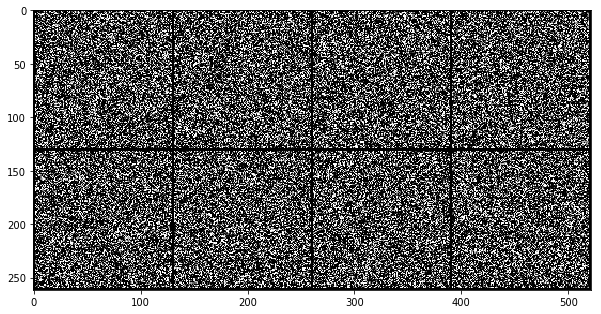

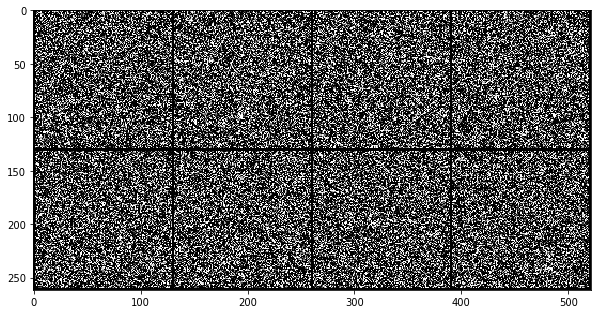

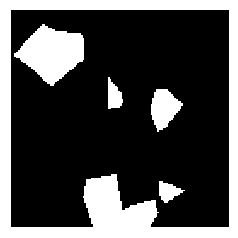

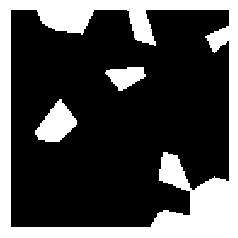

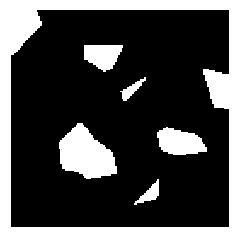

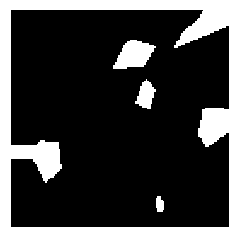

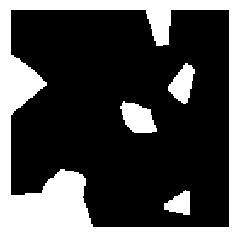

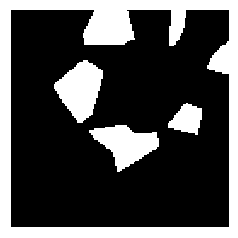

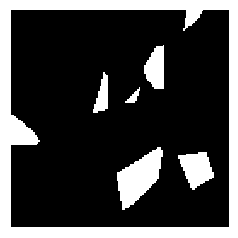

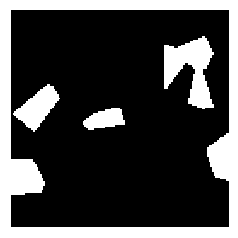

In [187]:
%autoreload 2
import time
from argparse import Namespace
from clevr import grid
import torchvision
args = specific_args
tic = time.time()
dset = grid.IIDXClusterGrid(args, n=100, n_regions=8, n_centers=64)
print("took {}s".format(time.time() - tic))
print(len(dset))
images = []
for i in range(dset.n_classes):
    images.append(torch.from_numpy(dset[i][0]).view(1, dset.s, dset.s))
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(torchvision.utils.make_grid(images, nrow=dset.n_regions // 2).numpy(), [1, 2, 0]))

images = []
for i in range(dset.n_classes):
    images.append(torch.from_numpy(dset[i + dset.n_classes][0]).view(1, dset.s, dset.s))
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(torchvision.utils.make_grid(images, nrow=dset.n_regions // 2).numpy(), [1, 2, 0]))
for i, r in dset.regions.items():
    plt.figure()
    plt.imshow(r, cmap='gray')
    plt.axis('off')
    plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')


In [212]:
locs = modules['regionfgl'].net[0].A_packed_data[:720]
u = modules['regionfgl'].net[0].nf_weight[:, locs]

In [229]:
modules['regionfgl'].fc[0].weight[:, ]

torch.Size([8, 128])